# Harringtonine: CropArray - Cellpose

---

## Notebook summary 


- Load a microscope image of video
- Tracking spots on the image and generate a pandas dataframe with the spots locations
- Creating a croparray with the image and dataframe
- Signal quantification and plotting
- Visualization of croparray with Napari

----

## Importing libraries


----

In [1]:
# To manipulate arrays
import numpy as np 
from skimage.io import imread
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()  
import pathlib # for working with windows paths
import sys
import trackpy as tp
import pandas as pd
import xarray as xr
# Segmenting using cellpose
from cellpose import models, core
#import warnings
#warnings.filterwarnings('ignore')
# Importing croparray
current_dir = pathlib.Path().absolute()
croparray_dir = current_dir.parents[0].joinpath('croparray')
sys.path.append(str(croparray_dir))
import crop_array_tools as ca
ca.print_banner()
# %matplotlib inline 
plt.style.use('dark_background')

 
░█████╗░██████╗░░█████╗░██████╗░░█████╗░██████╗░██████╗░░█████╗░██╗░░░██╗
██╔══██╗██╔══██╗██╔══██╗██╔══██╗██╔══██╗██╔══██╗██╔══██╗██╔══██╗╚██╗░██╔╝
██║░░╚═╝██████╔╝██║░░██║██████╔╝███████║██████╔╝██████╔╝███████║░╚████╔╝░
██║░░██╗██╔══██╗██║░░██║██╔═══╝░██╔══██║██╔══██╗██╔══██╗██╔══██║░░╚██╔╝░░
╚█████╔╝██║░░██║╚█████╔╝██║░░░░░██║░░██║██║░░██║██║░░██║██║░░██║░░░██║░░░
░╚════╝░╚═╝░░╚═╝░╚════╝░╚═╝░░░░░╚═╝░░╚═╝╚═╝░░╚═╝╚═╝░░╚═╝╚═╝░░╚═╝░░░╚═╝░░░
                                     by : Luis Aguilera and Tim Stasevich 




## File paths


----

In [2]:
img_path_1 = current_dir.parents[0].joinpath('database','20220210_metabolites_PEP_10mM_Max','MAX_Cell01.tif') 
img_path_2 = current_dir.parents[0].joinpath('database','20220210_metabolites_PEP_10mM_Max','MAX_Cell02_best.tif') 
img_path_3 = current_dir.parents[0].joinpath('database','20220210_metabolites_PEP_10mM_Max','MAX_Cell03.tif') 
img_path_4 = current_dir.parents[0].joinpath('database','20220210_metabolites_PEP_10mM_Max','MAX_Cell04_awesome_stalling.tif') 
img_path_5 = current_dir.parents[0].joinpath('database','20220210_metabolites_PEP_10mM_Max','MAX_Cell05.tif') 

list_img_path = [img_path_1,img_path_2,img_path_3,img_path_4,img_path_5]
print(list_img_path[0])

/Users/luisaguilera/Desktop/croparray/database/20220210_metabolites_PEP_10mM_Max/MAX_Cell01.tif


## Code parameters

In [3]:
nulceus_diameter_size = 100   # dimenssion in pixels
cytosol_diameter_size = 200   # dimenssion in pixels
particle_diameter = 7         # dimenssion in pixels
min_mass_intensity = 1000     # minimal intensity to detect an spot

## Loading data


----

In [4]:
def show_image(list_img_path):
    for _,img_path in enumerate(list_img_path):  # F, Y, X, C 
        img =  imread(str(img_path))
        selected_time = 0
        print(img_path.stem)
        print('original image shape: ', img.shape)
        # Plotting original image
        num_channels = img.shape[3] #3
        fig, ax = plt.subplots(nrows=1, ncols=num_channels,figsize=(15,7))
        for i in range(0,num_channels):
            ax[i].imshow(img[selected_time,:,:,i],cmap='viridis' )
            ax[i].grid(False)
            ax[i].set_title('Channel_'+str(i))
        plt.show()
    return None

MAX_Cell01
original image shape:  (65, 512, 512, 3)


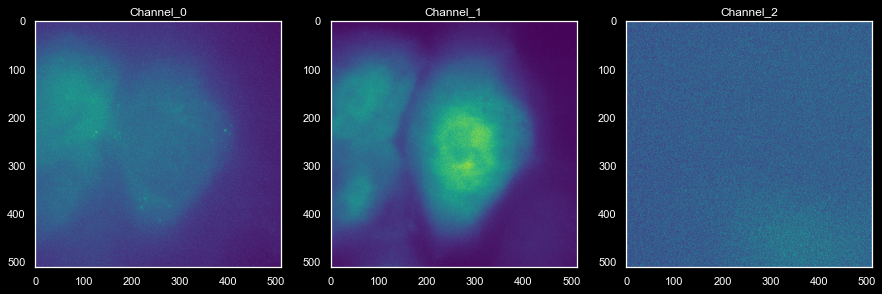

MAX_Cell02_best
original image shape:  (65, 512, 512, 3)


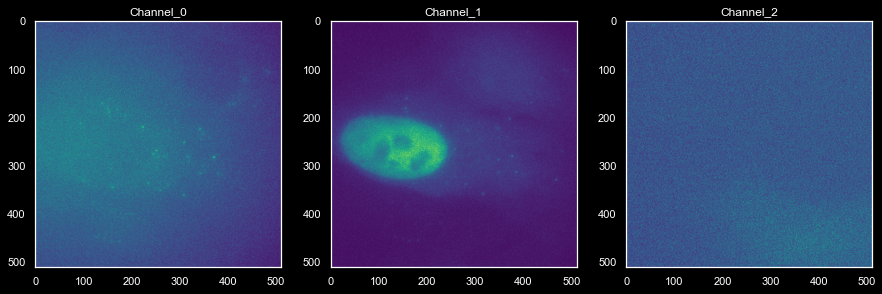

MAX_Cell03
original image shape:  (65, 512, 512, 3)


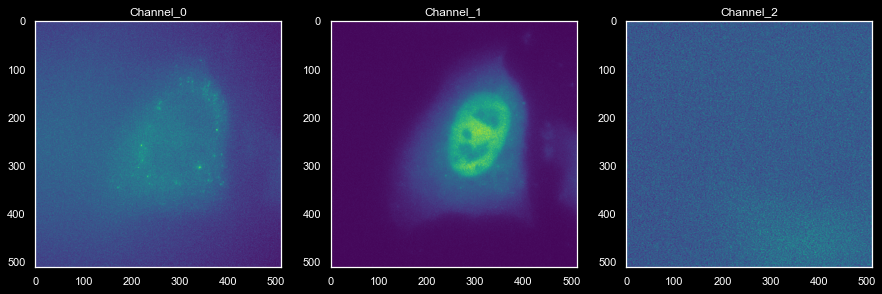

MAX_Cell04_awesome_stalling
original image shape:  (65, 512, 512, 3)


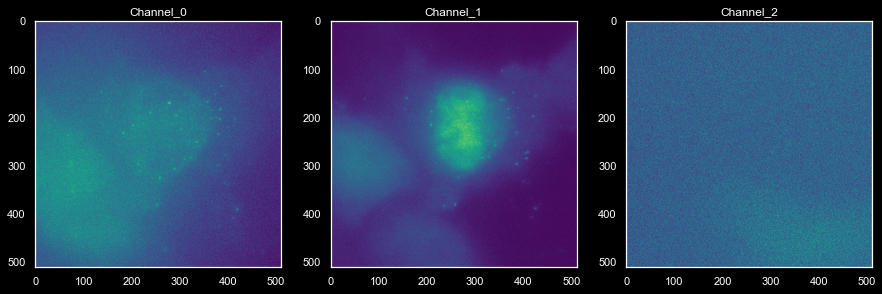

MAX_Cell05
original image shape:  (65, 512, 512, 3)


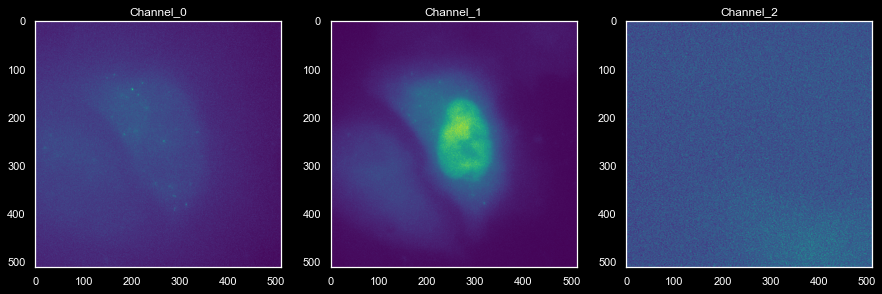

In [5]:
show_image(list_img_path)

# Segmentation using Cellpose

In [6]:
def segmentation(list_img_path,cytosol_diameter_size,nulceus_diameter_size):
    list_masks_cyto_complete=[]
    list_masks_nuc=[]
    list_masks_cyto_no_nucleus=[]
    
    for _,img_path in enumerate(list_img_path):  # F, Y, X, C 
        img =  imread(str(img_path))
        print(img_path.stem)
        # Converting the video to Croparray format
        selected_time=0
        selected_channel=1
        # parameters for cellpose
        channels = [0,0]
        # Cellpose Model
        model = models.Cellpose(gpu=core.use_gpu(), model_type='cyto') # model_type='cyto' or model_type='nuclei'
        # Running the models
        masks_cyto, flows, styles, diams = model.eval(img[selected_time,:,:,selected_channel], diameter=cytosol_diameter_size, flow_threshold=None, channels=channels)
        # Cellpose model
        model = models.Cellpose(gpu=core.use_gpu(), model_type='nuclei') # model_type='cyto' or model_type='nuclei'
        # Running the models
        masks_nuc, flows, styles, diams = model.eval(img[selected_time,:,:,selected_channel], diameter=nulceus_diameter_size, flow_threshold=None, channels=channels)

        # keeping only the largest mask.
        num_masks_nuc = np.amax(masks_nuc)
        if num_masks_nuc >1:
            masks_nuc_area = [np.count_nonzero(masks_nuc==j) for j in range(1, num_masks_nuc+1)]
            largest_mask = np.argmax(masks_nuc_area) +1   
            masks_nuc =  np.where(masks_nuc == largest_mask, 1, 0) 

        # Keeping only masks with nucleus
        def is_nucleus_in_cytosol(mask_n, mask_c):
            ''' This function detects if a cytosol has a nucleus. Returns 1 if true.'''
            mask_n[mask_n>1]=1
            mask_c[mask_c>1]=1
            size_mask_n = np.count_nonzero(mask_n)
            mask_combined =  mask_n + mask_c
            sum_mask = np.count_nonzero(mask_combined[mask_combined==2])
            if (sum_mask> size_mask_n*0.8): # the element is inside if the two masks overlap over the 80% of the smaller mask.
                return 1
            else:
                return 0
            
        # Looking if the mask has a nucleus
        number_cytosols = np.amax(masks_cyto)
        is_cyto_with_a_nucleus = np.zeros(number_cytosols,dtype='int') # prealocating an array
        for i in range (1,number_cytosols+1): # iterating for each mask in the cytosol 
            masks_cyto_temp =  np.where(masks_cyto == i, 1, 0)
            is_cyto_with_a_nucleus[i-1] = is_nucleus_in_cytosol(masks_nuc, masks_cyto_temp)

        # removing cytosol masks without nucleus
        masks_cyto_complete = np.zeros_like(masks_cyto) # Prealocating an array to contain the final masks 
        counter = 1
        for i in range (1,number_cytosols+1): # iterating for each mask in the cytosol 
            if is_cyto_with_a_nucleus[i-1] == True:
                # Keeping only the masks with a  nucleus
                masks_cyto_complete =  np.where(masks_cyto == i, counter, 0) 
                counter+=1
        # cytosol without nucleus
        masks_cyto_no_nucleus = masks_cyto_complete - masks_nuc

        # Plotting
        num_col = 3
        fig, ax = plt.subplots(nrows=1, ncols=num_col,figsize=(15,7))
        ax[0].imshow(masks_cyto_complete,cmap='Greys' )
        ax[0].set_title('Cytosol + nuc')
        ax[1].imshow(masks_nuc,cmap='Greys')
        ax[1].set_title('nucleus')
        ax[2].imshow(masks_cyto_no_nucleus,cmap='Greys')
        ax[2].set_title('cytosol wo nuc')
        plt.show()
        
        # appending masks to a list
        list_masks_cyto_complete.append(masks_cyto_complete)
        list_masks_nuc.append(masks_nuc)
        list_masks_cyto_no_nucleus.append(masks_cyto_no_nucleus)
        
    return list_masks_cyto_complete,list_masks_nuc, list_masks_cyto_no_nucleus

MAX_Cell01


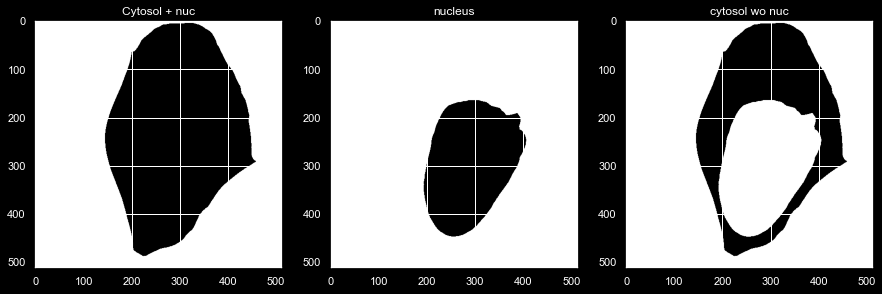

MAX_Cell02_best


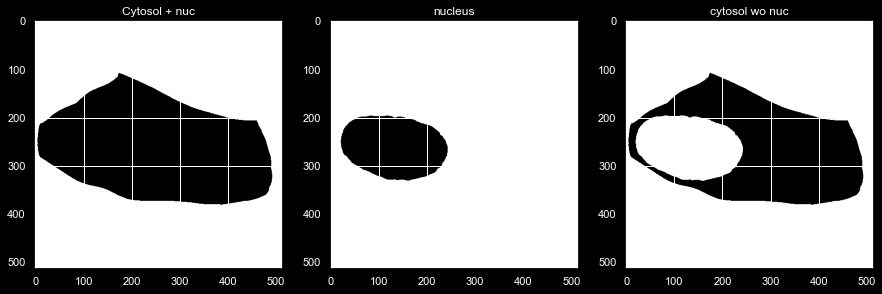

MAX_Cell03


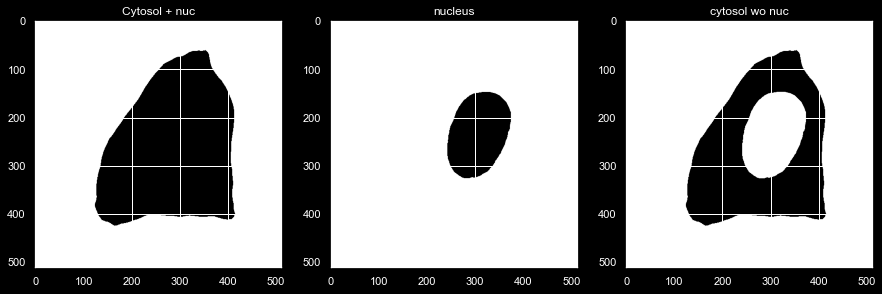

MAX_Cell04_awesome_stalling


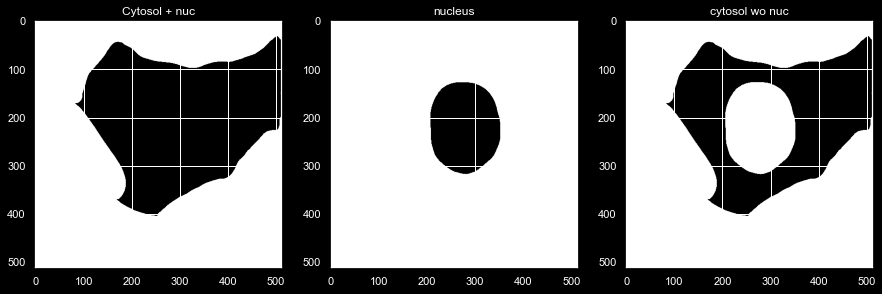

MAX_Cell05


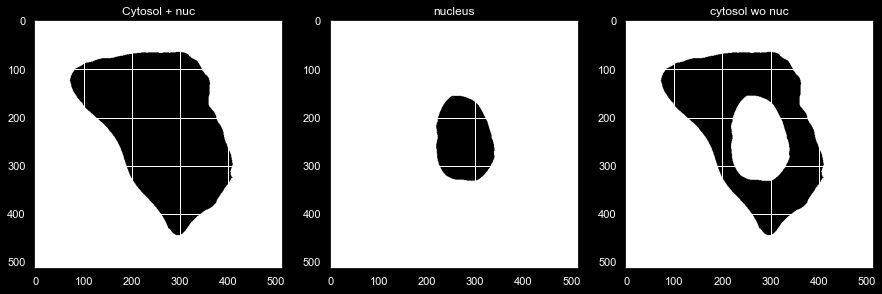

In [7]:
list_masks_cyto_complete,list_masks_nuc, list_masks_cyto_no_nucleus = segmentation(list_img_path,cytosol_diameter_size=cytosol_diameter_size,nulceus_diameter_size=nulceus_diameter_size)

In [8]:
def detect_spots(current_dir,list_img_path, list_masks_cyto_no_nucleus,list_masks_nuc,particle_diameter,min_mass_intensity ):
    list_dataframes=[]
    list_img_croparray=[]
    dataframe_directory =  current_dir.joinpath('dataframes')
    if not os.path.exists(str(dataframe_directory)):
            os.makedirs(str('dataframes'))
            
    for img_counter,img_path in enumerate(list_img_path):  # F, Y, X, C 
        # Directory to save data
        data_frame_file_name =  current_dir.joinpath('dataframes', img_path.stem+'.csv')
        # Function to detect spots inside a mask
        def spots_in_mask(f,mask,label):
            # extracting the contours in the image
            coords = np.array([f.y, f.x]).T # These are the points detected by trackpy
            coords_int = np.round(coords).astype(int)  # or np.floor, depends
            values_at_coords = mask[tuple(coords_int.T)] # If 1 the value is in the mask
            f[label]=values_at_coords # Check if pts are on/in polygon mask  
            return f 
        # loading image
        img =  imread(str(img_path))
        print(img_path.stem)
        
        # Making array with correct dimensions. 
        img_croparray = np.expand_dims(img,axis=0) # adding fov dimenssion
        img_croparray = np.expand_dims(img_croparray,axis=2) # adding z dimenssion
        img_croparray.shape # dimensions MUST be (fov, f , z, y, x, ch)
        img_croparray.shape
        print('croparray format shape [fov, f , z, y, x, ch] = ', img_croparray.shape)
        # Maximum projection
        img_max = np.max(img_croparray[0,:,:,:,:,1],axis=1)
        
        # iterating for all time points
        
        f = tp.batch(img_max, diameter=particle_diameter,minmass=min_mass_intensity)
        f_list = []
        for i in np.arange(len(f['frame'].unique())):
            f0 = f[f['frame']==i]
            f1 = f0.copy()
            # Label points in cell
            f1 = spots_in_mask(f1,list_masks_cyto_no_nucleus[img_counter],'In_Cell') 
            # Label points in nucleus
            f1 = spots_in_mask(f1,list_masks_nuc[img_counter],'In_Nucleus')
            f_list.append(f1)
        f_all = pd.concat(f_list)
        f_all.to_csv(data_frame_file_name)
        f_all
        list_dataframes.append(f_all)
        list_img_croparray.append(img_croparray)
        del f, f_all, f0, f1,f_list
    return list_dataframes,list_img_croparray

In [9]:
list_dataframes,list_img_croparray = detect_spots(current_dir,list_img_path, list_masks_cyto_no_nucleus,list_masks_nuc,particle_diameter,min_mass_intensity )

Frame 64: 93 features


Convert f to crop_array format

In [10]:
def convert_to_croparray_format(list_dataframes):
    list_spots_df=[]
    for _,f_all in enumerate(list_dataframes):  # F, Y, X, C 
        spots = f_all.copy() # Nice to copy; seems it can cause to overwrite otherwise
        spots['id']=spots.index
        spots.rename(columns={'x': 'xc','y': 'yc', 'frame': 'f','signal':'signal_tp'}, 
        inplace=True, errors='raise')
        spots['fov']=0
        spots.rename(columns={'particle':'id'})
        spots = spots[['fov','id','f','yc','xc','signal_tp','In_Cell','In_Nucleus']] # keeping signal out of curiousity... want to compare to disk-donut measurements  
        list_spots_df.append(spots)
    return list_spots_df

In [11]:
list_spots_df= convert_to_croparray_format(list_dataframes)

## Create Crop Array
____

In [12]:
list_croparrays=[]
for index_image,img_path in enumerate(list_img_path):
    my_ca = ca.create_crop_array(list_img_croparray[index_image],list_spots_df[index_image],xy_pad=particle_diameter//2+1, dxy=130, dz=500, dt=1, units=['nm','min'], name = img_path.stem)
    list_croparrays.append(my_ca)

Original video dimensions:  (1, 65, 1, 512, 512, 3)
Padded video dimensions:  (1, 65, 1, 522, 522, 3)
Max # of spots per frame:  255
Shape of numpy array to hold all crop intensity data:  (1, 255, 65, 1, 9, 9, 3)
Shape of xc and yc numpy arrays:  (1, 255, 65, 3)
Shape of extra my_layers numpy array:  (4, 1, 255, 65)
Original video dimensions:  (1, 65, 1, 512, 512, 3)
Padded video dimensions:  (1, 65, 1, 522, 522, 3)
Max # of spots per frame:  33
Shape of numpy array to hold all crop intensity data:  (1, 33, 65, 1, 9, 9, 3)
Shape of xc and yc numpy arrays:  (1, 33, 65, 3)
Shape of extra my_layers numpy array:  (4, 1, 33, 65)
Original video dimensions:  (1, 65, 1, 512, 512, 3)
Padded video dimensions:  (1, 65, 1, 522, 522, 3)
Max # of spots per frame:  128
Shape of numpy array to hold all crop intensity data:  (1, 128, 65, 1, 9, 9, 3)
Shape of xc and yc numpy arrays:  (1, 128, 65, 3)
Shape of extra my_layers numpy array:  (4, 1, 128, 65)
Original video dimensions:  (1, 65, 1, 512, 512, 3

## Quantify signal intensity through time
____

Cell MAX_Cell01


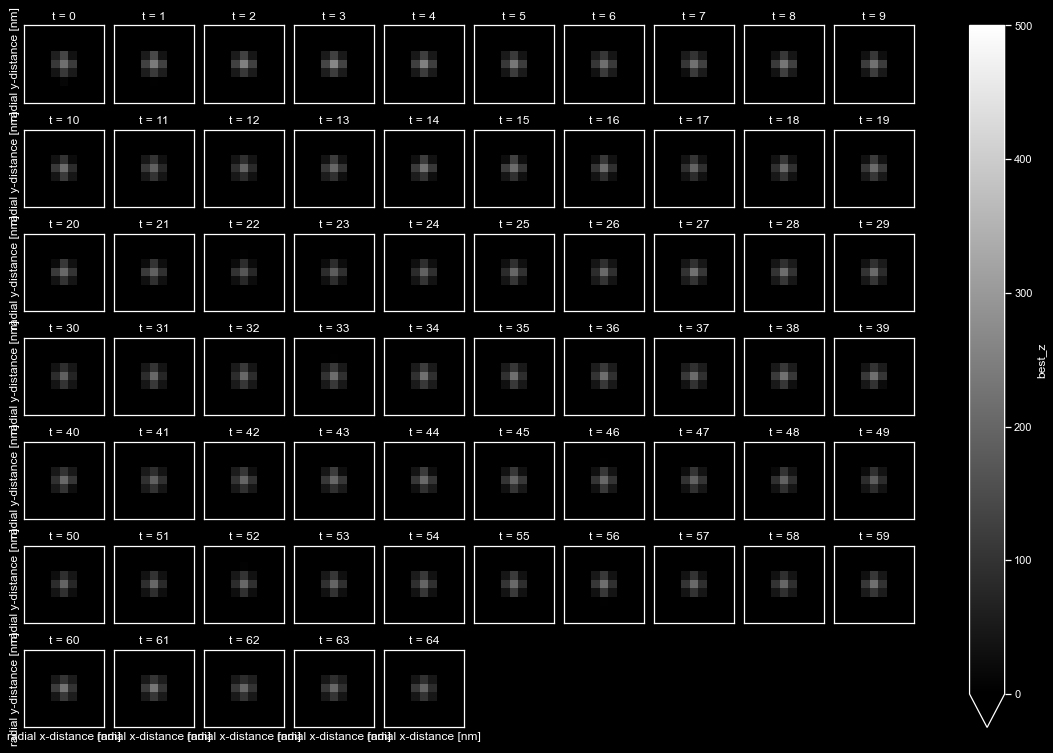

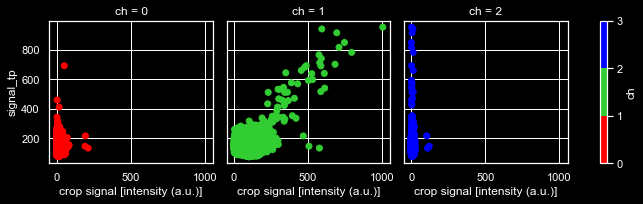

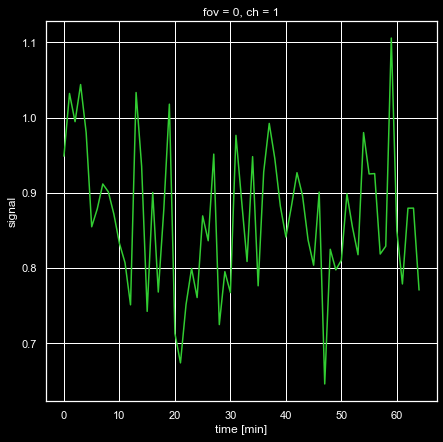

Cell MAX_Cell02_best


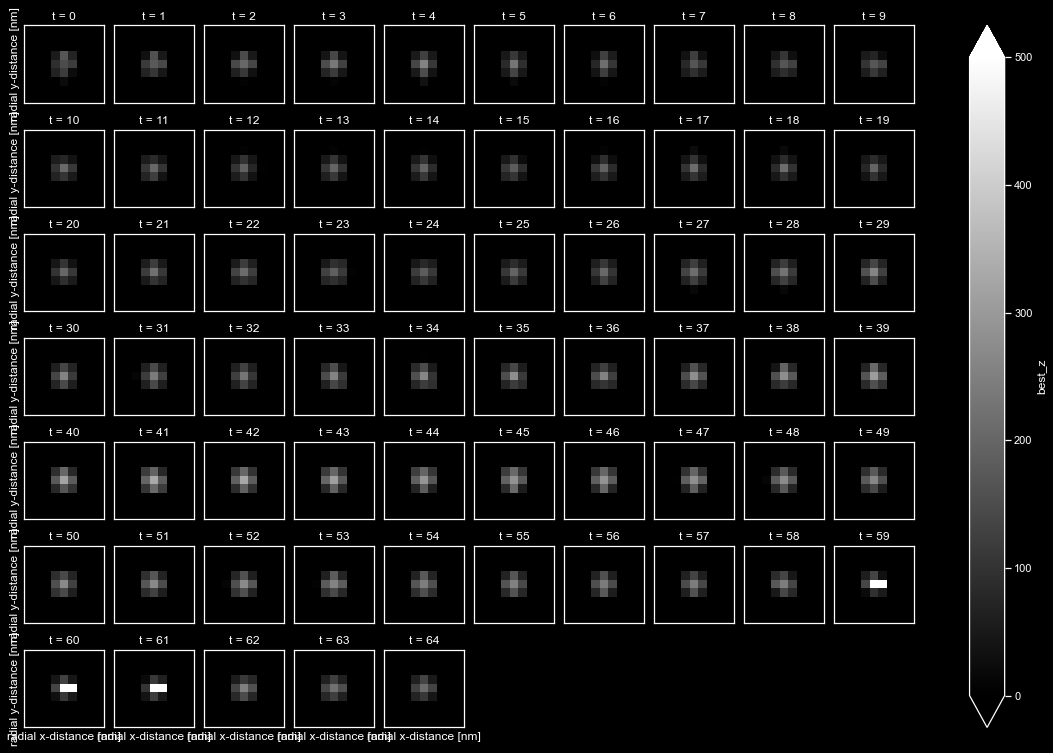

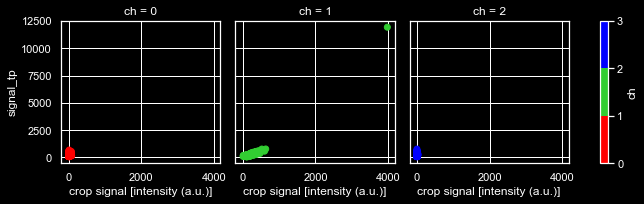

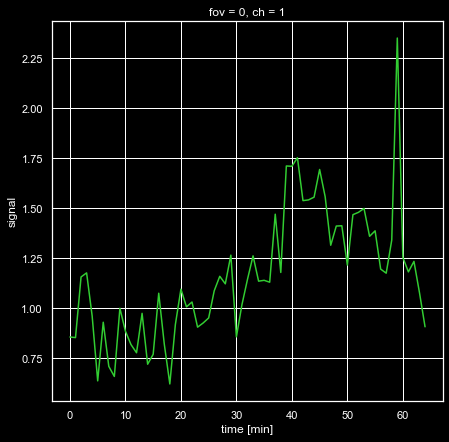

Cell MAX_Cell03


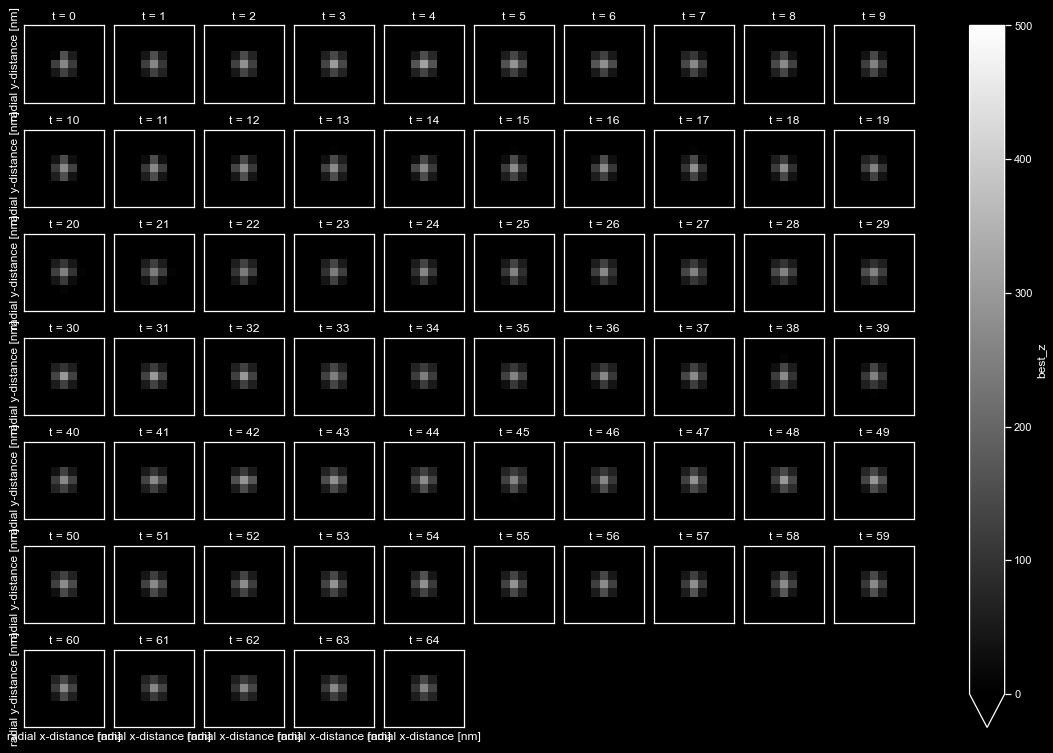

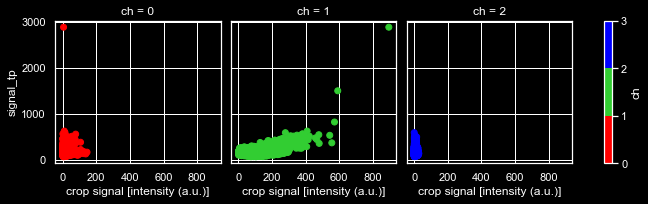

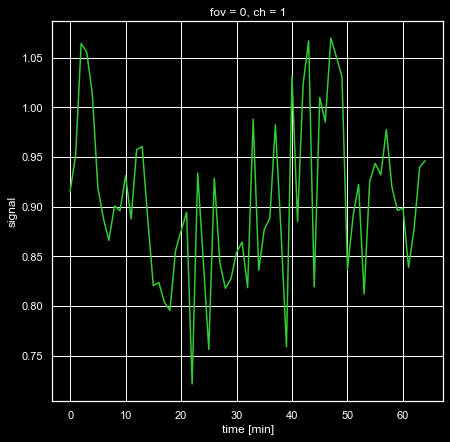

Cell MAX_Cell04_awesome_stalling


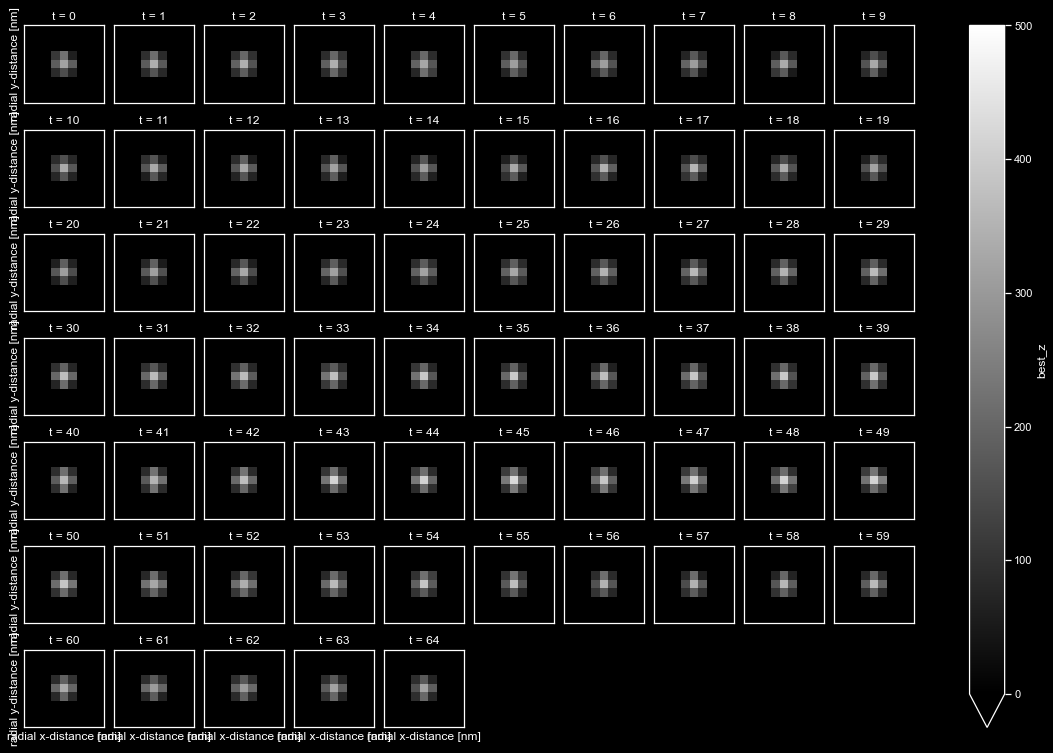

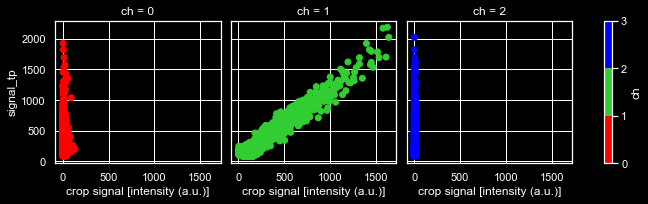

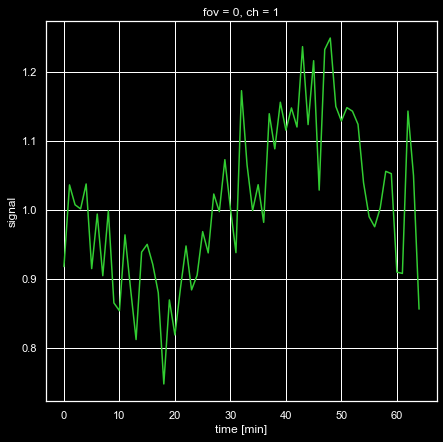

Cell MAX_Cell05


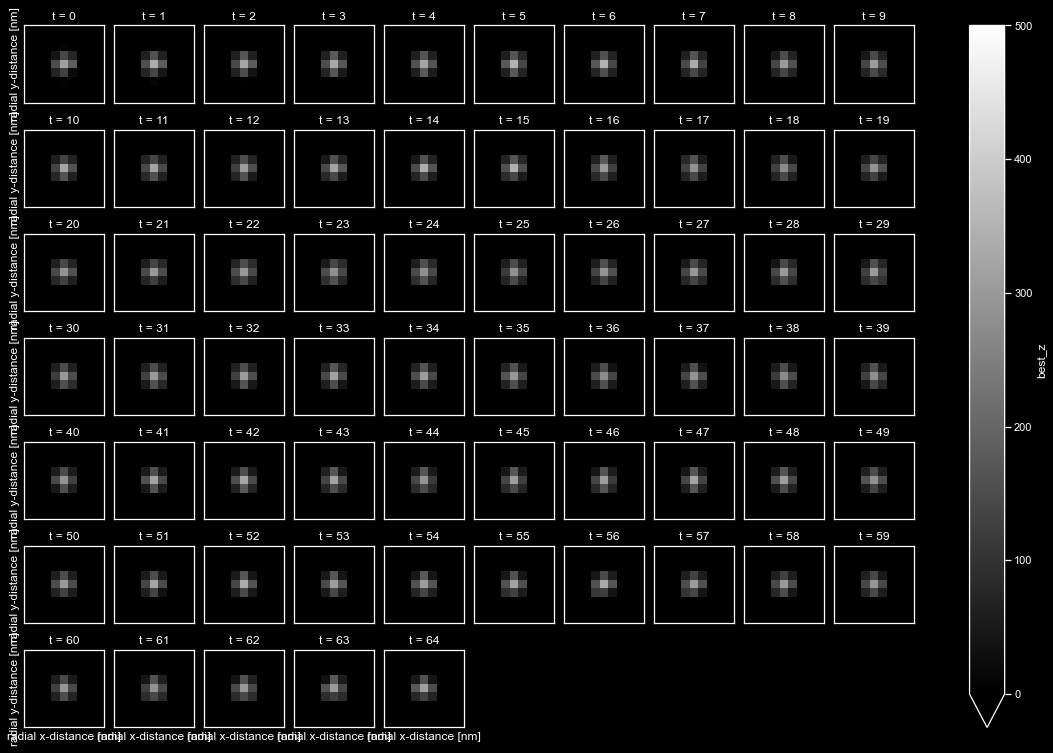

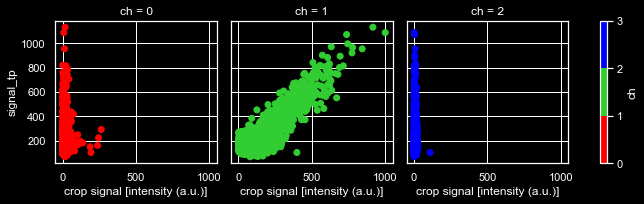

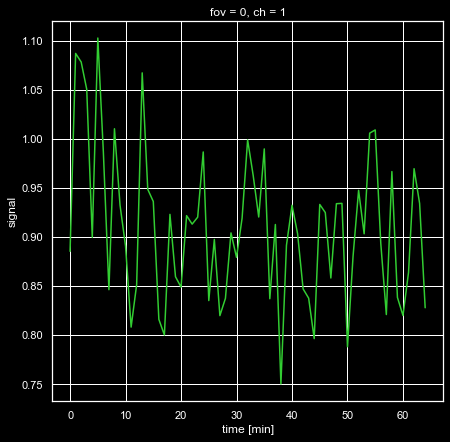

In [13]:
for index_image, my_ca in enumerate(list_croparrays):
    # Measure signals and plot average signal through time, creating 'best_z' layer and 'signal' layer
    ca.measure_signal(my_ca, ref_ch=1, disk_r=3, roll_n=3)
    my_ca.best_z.mean('n').sel(fov=0,ch=1).rolling(t=3,min_periods=1).mean().plot.imshow(col='t',col_wrap=10,robust=True,xticks=[],yticks=[],size=1.5,cmap='gray', vmin=0, vmax =500)
    my_ca.where(my_ca.signal>0).plot.scatter(x='signal',y='signal_tp',col='ch',hue='ch',colors=['red','limegreen','blue'],levels=[0,1,2,3])
    # Let's look at average signal vs time
    start_sig = my_ca.signal.mean('n').sel(t=slice(0,4)).mean('t')
    end_sig = 0# my_ca.signal.mean('n').sel(t=slice(15,20)).mean('t')
    norm_sig = (my_ca.signal.mean('n') - end_sig)/(start_sig - end_sig)
    print('Cell', list_img_path[index_image].stem)
    plt.figure(figsize=(7, 7))
    sns.set_palette(['limegreen','limegreen','blue'])
    norm_sig.sel(fov=0,ch=1).plot.line(x='t',hue='ch')
    plt.show()

## Visualize crop array montage with Napari
___

Now let's see a montage of the selected spots' best-z planes:

In [14]:
%gui qt5 
import napari
from napari.utils import nbscreenshot
viewer = napari.Viewer()

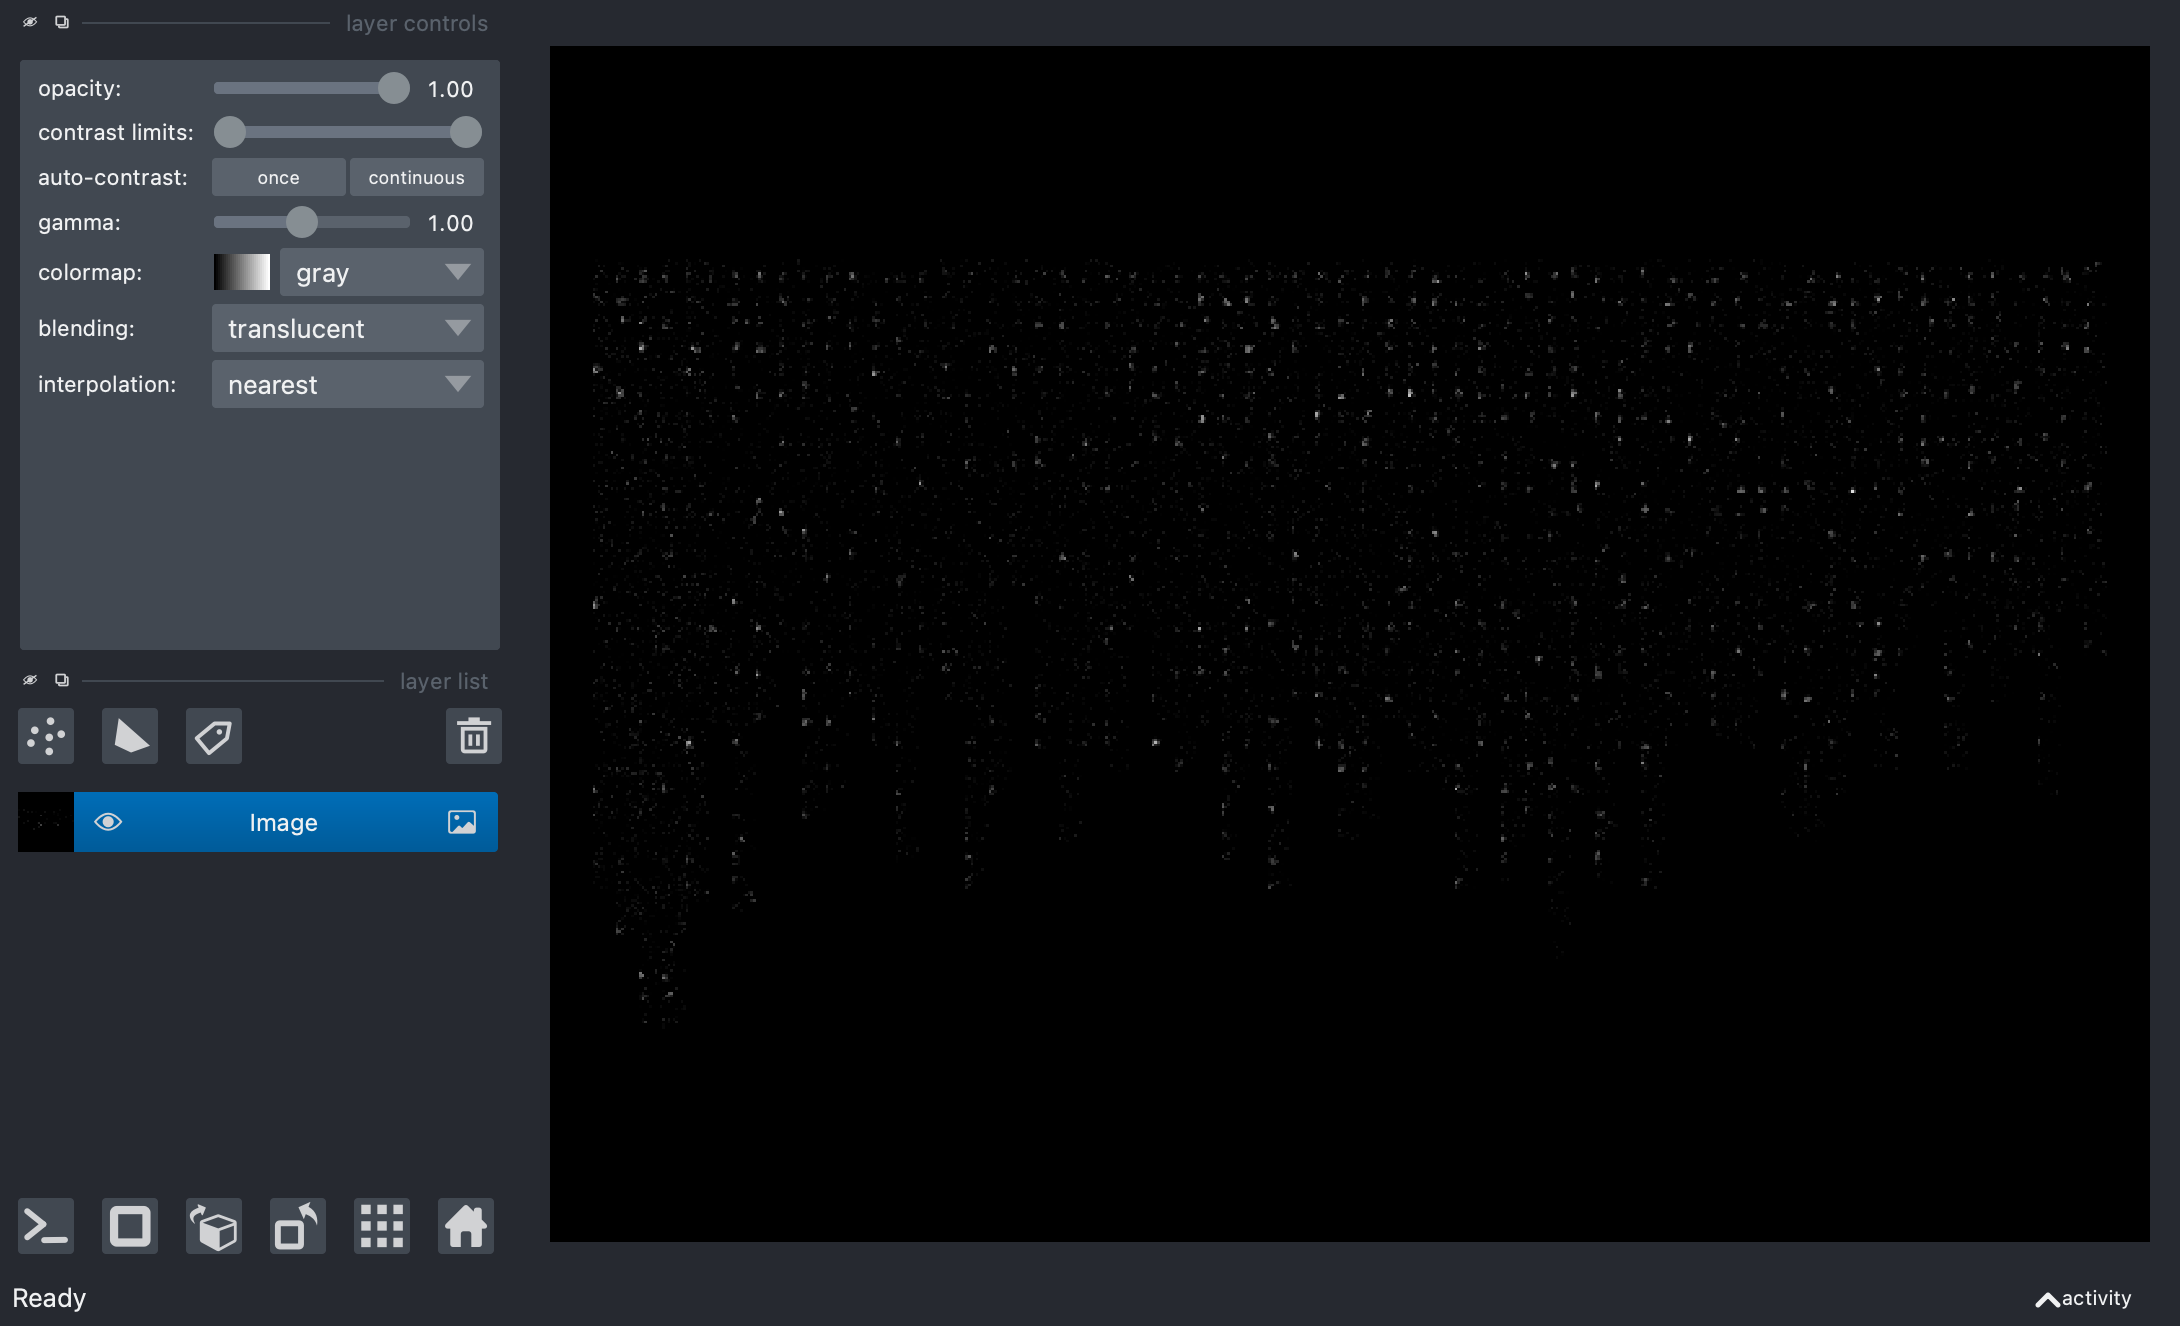

In [22]:
selected_image =1
my_ca_to_plot=list_croparrays[selected_image]
viewer = napari.view_image(ca.montage(my_ca_to_plot.sel(fov=0,ch=0).best_z,row='n',col='t'),contrast_limits=[60,800],visible=1)
nbscreenshot(viewer)

